In [1]:
%%bash

pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 41.5 MB/s eta 0:00:00


In [21]:
import pickle
import re
from konlpy.tag import Okt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer

loaded_model = load_model('best_model.h5')

okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','을','를','으로','자','에','와','한','하다']
max_len = 30

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

def sentiment_predict(new_sentence):
  new_sentence = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 댓글입니다.".format(score * 100))
    return 1
  else:
    print("{:.2f}% 확률로 부정 댓글입니다.".format((1 - score) * 100))
    return 0
  print("--------------------------------------------------------------------------------")
#-------------------------댓글 데이터 시각화------------------------------

comments = pd.read_csv('comments.csv')
# csv 형식의 파일을 데이터프레임으로 불러올 경우 1번째 열이 인덱싱 번호가 들어가 있음(제거하는 것이 편함)
comments.drop([comments.columns[0]], axis=1, inplace=True)
comments.head()

comment_dict = comments.to_dict()

comments_list = []

for sentence in tqdm(comments['comment']):
    sentence = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', sentence)
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    comments_list.append(stopwords_removed_sentence)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(comments_list)


# 위에서 만들어진 예측함수를 활용하여 딕셔너리 내 댓글의 감성을 분석
cnt_pos=0
cnt_neg=0

for i in range(len(comment_dict.get('comment'))):
  print("--------------------------------------------------------------------------------")
  print("(%d)번 댓글 원문: %s"%(i+1, comment_dict.get('comment').get(i)))
  if sentiment_predict(comment_dict.get('comment').get(i)) == 1:
    cnt_pos += 1
  else:
    cnt_neg += 1

print("--------------------------------------------------------------------------------")
print("총 댓글의 수: %d"%(len(comment_dict.get('comment'))))
print("긍정적인 댓글의 수: %d"%(cnt_pos))
print("부정적인 댓글의 수: %d"%(cnt_neg))















100%|██████████| 39/39 [00:00<00:00, 79.22it/s]


--------------------------------------------------------------------------------
(1)번 댓글 원문: 우크라이나 힘내세요 애국심으로 힘을 합쳐서 꼭 승리 부탁드립니다 항상 상암동에서 응원합니다 세아이 아빠 강 석 종
1/1 [==============================] - 0s 452ms/step
70.81% 확률로 긍정 댓글입니다.
--------------------------------------------------------------------------------
(2)번 댓글 원문: 근데 일부에선 바흐무트전투는 전술적으로 큰 의미가 없다는 말이 나오던데 그럼 지금까지 저기서 싸우다 죽어간 병사들은 뭣때문에 싸운거냐 그 갈아넣은 병사들의 죽음을 한순간에 개죽음으로 만들던데
1/1 [==============================] - 0s 23ms/step
69.53% 확률로 긍정 댓글입니다.
--------------------------------------------------------------------------------
(3)번 댓글 원문: 솔직히 정규부대도 아닌 죄수들에게 최대격전지인 바흐무트를 빼았긴거나 다름 없어서  상직적인 측면에서 타격이 좀 클듯.. 중요하지 않았다면 처음부터 그 많은 군인을 갈아넣으면서 지킬 필요도 없었겠지 .. 이제와서 신포도 타령하는 여우 흉내내기엔 너무 늦지않았나?
1/1 [==============================] - 0s 22ms/step
96.71% 확률로 긍정 댓글입니다.
--------------------------------------------------------------------------------
(4)번 댓글 원문: 자유를 쟁취하기 위해선 얼마만큼의 희생과 피를 필요로합니다. 이번 전쟁으로 우라에 자유진영이 굳건히 들어서길 희망하며 전쟁에서도 승리하길~
1/1 [========

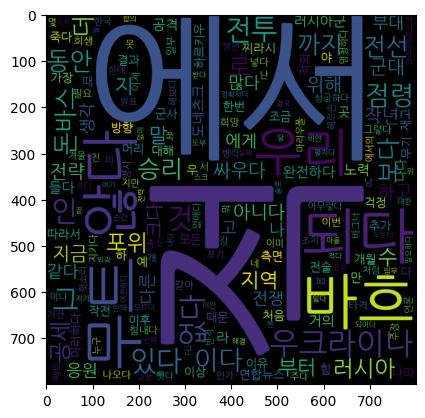

In [25]:
from wordcloud import WordCloud

# 유튜브 댓글 데이터 키워드 시각화
wc = WordCloud(font_path='NanumGothic.ttf', width=400, height=400, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(tokenizer.word_counts)
plt.figure()
plt.imshow(gen)